<h1>Leaf Disease Prediction</h1>
<img 
style="width : 100%;margin: auto;"    
src="https://www.google.com/search?q=leaf+disease&sxsrf=ALiCzsb-Fr5LvT82eoxXJt3fDQmP8Qo_cA:1654161628719&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiGpZ-iuI74AhVKBaYKHYEJBIMQ_AUoAXoECAIQAw&biw=1707&bih=806&dpr=1.13#imgrc=BJHS-ZYd7zmuTM&imgdii=O8NuCBPDZa8ipM>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import matplotlib.pyplot as plt
tf.compat.v1.set_random_seed(0)
from tensorflow import keras
import numpy as np
np.random.seed(0)
import itertools
from keras.preprocessing.image import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

<h1>Data Loading</h1>
<p>Setting up Image Data Generators<p>

In [2]:
#train_gen = image_dataset_from_directory(directory="../input/new-plant-diseases-dataset/train",image_size=(256, 256))
#test_gen = image_dataset_from_directory(directory="../input/new-plant-diseases-dataset/valid",image_size=(256, 256))

train_gen = image_dataset_from_directory(directory="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
                                         image_size=(256, 256))
test_gen = image_dataset_from_directory(directory="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
                                        image_size=(256, 256))

rescale = Rescaling(scale=1.0/255)
train_gen = train_gen.map(lambda image,label:(rescale(image),label))
test_gen  = test_gen.map(lambda image,label:(rescale(image),label))

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


<h1>Data Engineering</h1>
<p>Since the data is already augmented, there is no requirement of data engineering. Feature scaling is automatically done by image generators</p>

### Modeling 

In [3]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(32,(3,3),activation="relu",padding="same",input_shape=(256,256,3)))
model.add(keras.layers.Conv2D(32,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Conv2D( 256,(3,3),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(256,(3,3),activation="relu",padding="same"))

model.add(keras.layers.Conv2D(512,(5,5),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(512,(5,5),activation="relu",padding="same"))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(1568,activation="relu"))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(38,activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 85, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       7

In [4]:
ep = 10
history = model.fit_generator(train_gen,
          validation_data=test_gen,
          epochs = ep)

Epoch 1/10
2197/2197 [==============================] - 385s 170ms/step - loss: 1.5659 - accuracy: 0.5448 - val_loss: 0.5501 - val_accuracy: 0.8284
Epoch 2/10
2197/2197 [==============================] - 346s 157ms/step - loss: 0.4259 - accuracy: 0.8648 - val_loss: 0.3166 - val_accuracy: 0.8963
Epoch 3/10
2197/2197 [==============================] - 347s 158ms/step - loss: 0.2497 - accuracy: 0.9188 - val_loss: 0.2482 - val_accuracy: 0.9211
Epoch 4/10
2197/2197 [==============================] - 363s 165ms/step - loss: 0.1702 - accuracy: 0.9437 - val_loss: 0.1708 - val_accuracy: 0.9458
Epoch 5/10
2197/2197 [==============================] - 346s 157ms/step - loss: 0.1282 - accuracy: 0.9567 - val_loss: 0.1622 - val_accuracy: 0.9487
Epoch 6/10
2197/2197 [==============================] - 345s 157ms/step - loss: 0.0974 - accuracy: 0.9675 - val_loss: 0.2722 - val_accuracy: 0.9200
Epoch 7/10
2197/2197 [==============================] - 344s 157ms/step - loss: 0.0794 - accuracy: 0.9738 - val_

In [5]:
model.save("plant_disease.h5")

In [6]:
import tensorflow as tf

model = tf.keras.models.load_model('/kaggle/working/plant_disease.h5')


In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


In [8]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


In [9]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/kaggle/working/model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load the image
image = Image.open("/kaggle/input/new-plant-diseases-dataset/test/test/AppleCedarRust1.JPG").convert("RGB")
image = image.resize((input_details[0]['shape'][1], input_details[0]['shape'][2]))

# Prepare input data
input_data = np.expand_dims(image, axis=0)
input_data = input_data.astype(np.float32)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Process the output
prediction = np.argmax(output_data[0])


In [10]:
prediction

4

<h1>Metrics</h1>

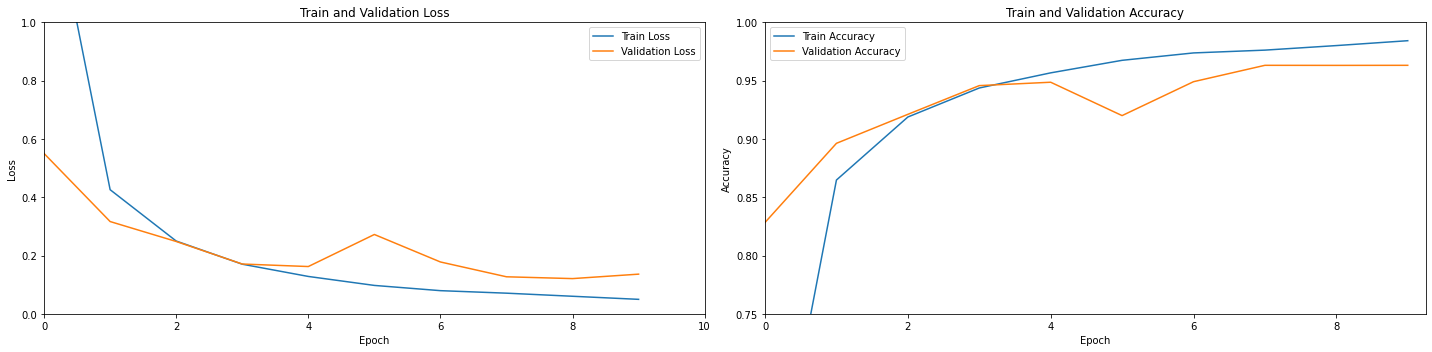

In [11]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [12]:
labels = []
predictions = []
for x,y in test_gen:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

In [13]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [14]:
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Train Accuracy  : 98.43 %
Test Accuracy   : 96.32 %
Precision Score : 96.32 %
Recall Score    : 96.32 %


<h3>Confusion Matrix</h3>

<Figure size 1440x360 with 0 Axes>

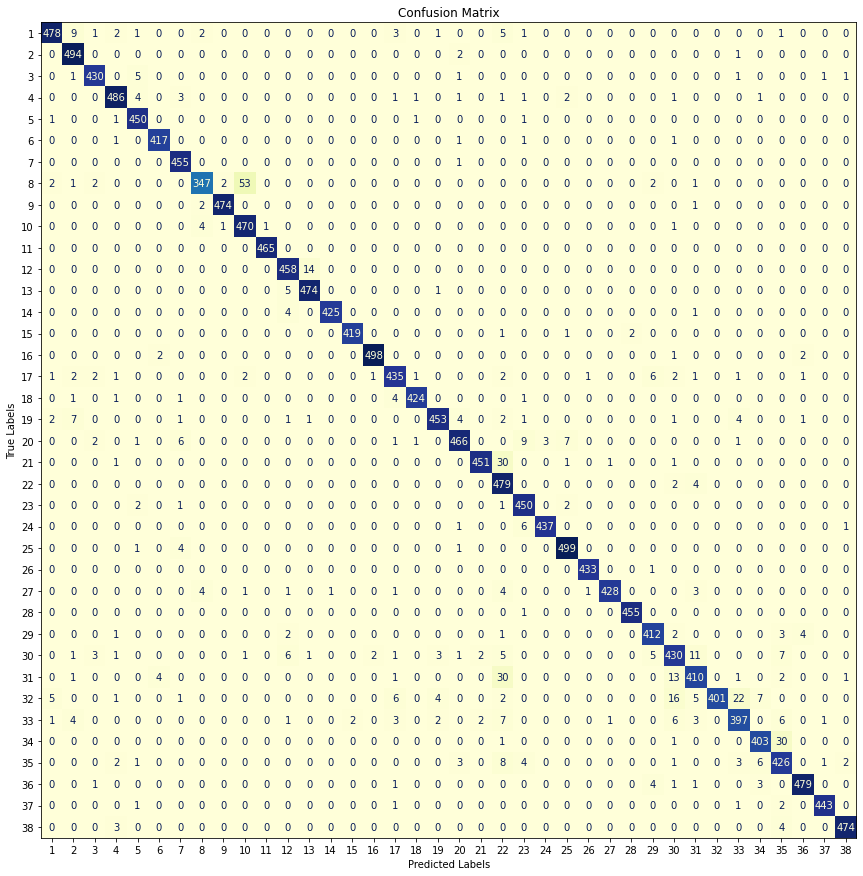

In [15]:
plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()